# **Assignment 3 - Time-Series Data**

# **Name: Mohana Krishna**

# **Kent ID: 811292363**

**A temperature forecasting example**

In [1]:
import requests
import zipfile
import io

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    zf.extractall()

**Analysis of the data of the Jena weather dataset - 420451 rows and 15 Features**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**After analyzing the data, certain values are stored in the temperature and raw_data arrays for later processing or analysis. The comma-separated values are converted into floating-point numbers.**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plot for the temperature timeseries**

Text(0, 0.5, 'Temperature')

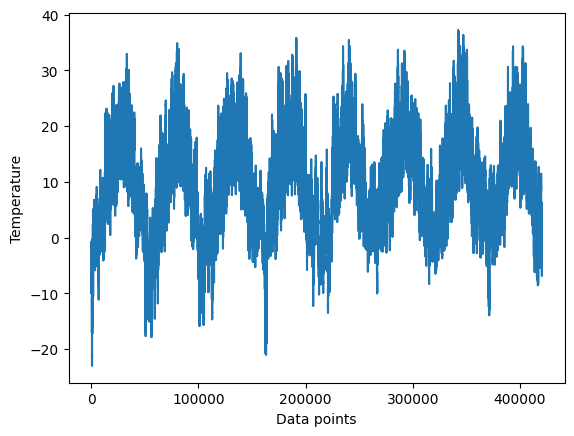

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the temperature timeseries for first ten days: Given that 144 data points are collected in a single day, 10 days will result in 1440 data points**

Text(0, 0.5, 'Temperature')

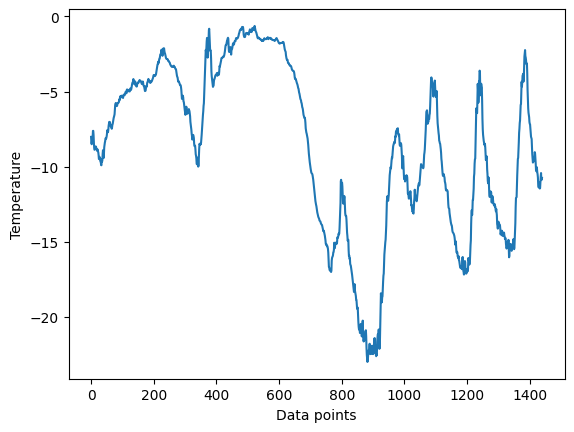

In [5]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Calculating the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data: Vectorization is not required because the data is already in a numerical representation. Still, it is advised to normalize all variables because the data scales vary amongst them, with temperature ranging from -20 to +30 and pressure measured in millibars.**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Generating training, validation, and testing datasets—this is necessary due to the large degree of redundancy in the dataset's samples. Therefore, it would be inefficient to explicitly allocate RAM for every sample. Rather, the samples will be produced dynamically**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Generating the output of one of this datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Calculating the common-sense baseline MAE: The "evaluate_naive_method" defined function offers a starting point for assessing the effectiveness of a basic forecasting technique that uses the final value in the input sequence in order to predict the value that will come after it.**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [14]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 8s 9ms/step - loss: 12.1492 - mae: 2.6884 - val_loss: 10.1902 - val_mae: 2.5147
Epoch 2/10
819/819 [==============================] - 6s 7ms/step - loss: 8.9443 - mae: 2.3513 - val_loss: 14.3039 - val_mae: 3.0081
Epoch 3/10
819/819 [==============================] - 5s 6ms/step - loss: 8.3270 - mae: 2.2719 - val_loss: 11.1725 - val_mae: 2.6381
Epoch 4/10
819/819 [==============================] - 5s 7ms/step - loss: 7.9021 - mae: 2.2156 - val_loss: 10.9408 - val_mae: 2.6144
Epoch 5/10
819/819 [==============================] - 5s 7ms/step - loss: 7.5725 - mae: 2.1669 - val_loss: 11.7380 - val_mae: 2.6996
Epoch 6/10
819/819 [==============================] - 6s 7ms/step - loss: 7.3386 - mae: 2.1344 - val_loss: 10.5987 - val_mae: 2.5719
Epoch 7/10
819/819 [==============================] - 6s 7ms/step - loss: 7.1337 - mae: 2.1052 - val_loss: 12.4885 - val_mae: 2.7753
Epoch 8/10
819/819 [==============================] - 5s 7ms/step - 

In [16]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 6ms/step - loss: 11.1326 - mae: 2.6291
Test MAE: 2.63


**Plotting results**

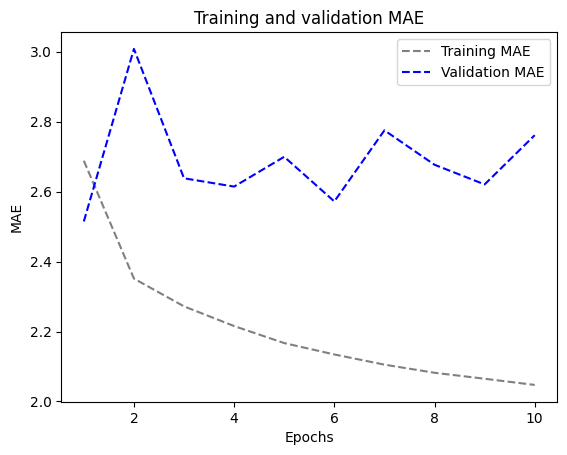

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 22ms/step - loss: 21.6328 - mae: 3.6432 - val_loss: 17.4906 - val_mae: 3.3583
Epoch 2/10
819/819 [==============================] - 17s 20ms/step - loss: 15.0159 - mae: 3.0657 - val_loss: 17.3424 - val_mae: 3.3047
Epoch 3/10
819/819 [==============================] - 17s 20ms/step - loss: 13.8405 - mae: 2.9410 - val_loss: 15.9174 - val_mae: 3.1471
Epoch 4/10
819/819 [==============================] - 17s 20ms/step - loss: 13.0802 - mae: 2.8570 - val_loss: 14.9769 - val_mae: 3.0592
Epoch 5/10
819/819 [==============================] - 17s 20ms/step - loss: 12.4711 - mae: 2.7873 - val_loss: 15.3321 - val_mae: 3.0909
Epoch 6/10
819/819 [==============================] - 16s 20ms/step - loss: 11.9624 - mae: 2.7282 - val_loss: 14.6705 - val_mae: 3.0160
Epoch 7/10
819/819 [==============================] - 17s 20ms/step - loss: 11.5412 - mae: 2.6796 - val_loss: 14.4362 - val_mae: 2.9872
Epoch 8/10
819/819 [============================

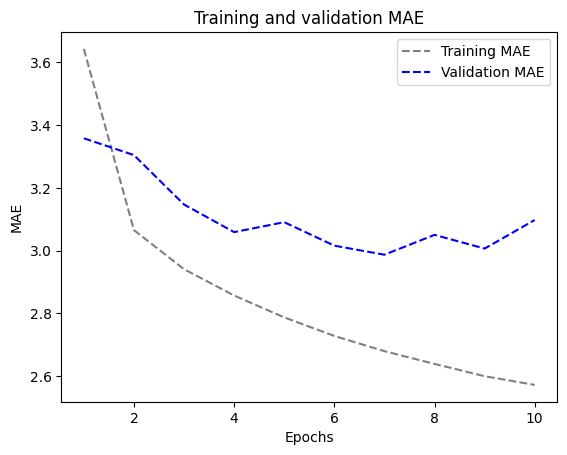

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Convolutional data appear to perform worse than dense models or common sense. It might be due to
- The translation invariance assumption does not hold true for weather data.
- The sequence in which the data is presented is critical. When it comes to forecasting the temperature for the next day, recent historical data is noticeably more useful than data collected several days before. Unfortunately, this important order of time cannot be captured well by a 1D convolutional neural network.





## **A Simple RNN**

### **1. An RNN layer that can process sequences of any length**

In [20]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 20ms/step - loss: 138.7487 - mae: 9.6968 - val_loss: 144.0980 - val_mae: 9.9140
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 136.4500 - mae: 9.5646 - val_loss: 143.7713 - val_mae: 9.8760
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 136.3452 - mae: 9.5575 - val_loss: 143.6765 - val_mae: 9.8661
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 136.2465 - mae: 9.5470 - val_loss: 143.6600 - val_mae: 9.8664
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 136.1891 - mae: 9.5416 - val_loss: 143.5909 - val_mae: 9.8578
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 136.1743 - mae: 9.5394 - val_loss: 143.5901 - val_mae: 9.8585
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 136.1430 - mae: 9.5355 - val_loss: 143.5736 - val_mae: 9.8557
Epoch 8/10
819/819 [==============

### **2. Simple RNN - Stacking RNN layers**

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 46s 54ms/step - loss: 136.9179 - mae: 9.5724 - val_loss: 143.5194 - val_mae: 9.8522
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 136.0042 - mae: 9.5187 - val_loss: 143.4216 - val_mae: 9.8394
Epoch 3/10
819/819 [==============================] - 42s 52ms/step - loss: 135.9267 - mae: 9.5091 - val_loss: 143.4283 - val_mae: 9.8400
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 135.8788 - mae: 9.5021 - val_loss: 143.4283 - val_mae: 9.8392
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 135.8587 - mae: 9.5001 - val_loss: 143.4297 - val_mae: 9.8404
Epoch 6/10
819/819 [==============================] - 43s 53ms/step - loss: 135.8409 - mae: 9.4976 - val_loss: 143.4191 - val_mae: 9.8389
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 135.8192 - mae: 9.4944 - val_loss: 143.4232 - val_mae: 9.8363
Epoch 8/10
819/819 [==============

## **A Simple GRU (Gated Recurrent Unit)**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 58ms/step - loss: 36.8153 - mae: 4.4080 - val_loss: 12.3776 - val_mae: 2.6517
Epoch 2/10
819/819 [==============================] - 46s 57ms/step - loss: 10.5177 - mae: 2.5219 - val_loss: 9.8539 - val_mae: 2.4015
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 9.6109 - mae: 2.4172 - val_loss: 9.6968 - val_mae: 2.3860
Epoch 4/10
819/819 [==============================] - 47s 58ms/step - loss: 9.3258 - mae: 2.3809 - val_loss: 10.0953 - val_mae: 2.4143
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 9.1178 - mae: 2.3563 - val_loss: 9.5087 - val_mae: 2.3684
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 8.8884 - mae: 2.3293 - val_loss: 9.9062 - val_mae: 2.3982
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 8.6404 - mae: 2.2999 - val_loss: 10.0089 - val_mae: 2.4070
Epoch 8/10
819/819 [==============================] - 45s

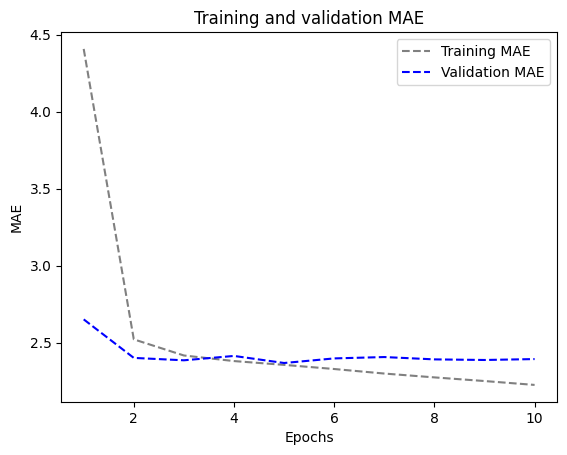

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 71s 83ms/step - loss: 42.6917 - mae: 4.7589 - val_loss: 13.2353 - val_mae: 2.7722
Epoch 2/10
819/819 [==============================] - 62s 76ms/step - loss: 10.9144 - mae: 2.5598 - val_loss: 10.0298 - val_mae: 2.4522
Epoch 3/10
819/819 [==============================] - 55s 67ms/step - loss: 9.6464 - mae: 2.4147 - val_loss: 10.3853 - val_mae: 2.4973
Epoch 4/10
819/819 [==============================] - 58s 71ms/step - loss: 9.1300 - mae: 2.3466 - val_loss: 9.8096 - val_mae: 2.4351
Epoch 5/10
819/819 [==============================] - 61s 74ms/step - loss: 8.7422 - mae: 2.2999 - val_loss: 9.9443 - val_mae: 2.4482
Epoch 6/10
819/819 [==============================] - 53s 65ms/step - loss: 8.3853 - mae: 2.2560 - val_loss: 10.1814 - val_mae: 2.4707
Epoch 7/10
819/819 [==============================] - 47s 58ms/step - loss: 8.0939 - mae: 2.2200 - val_loss: 10.4406 - val_mae: 2.5078
Epoch 8/10
819/819 [==============================] - 6

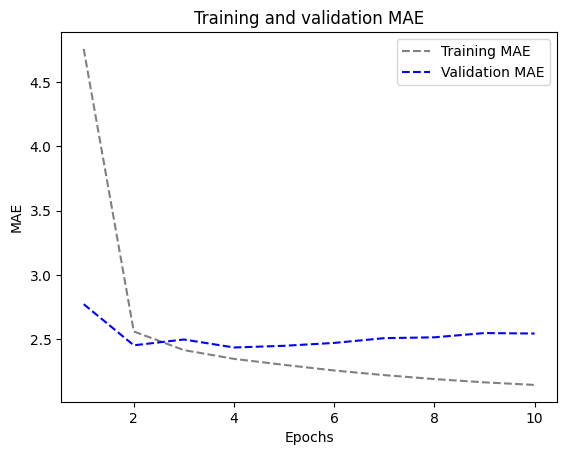

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM - dropout Regularization**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 84s 100ms/step - loss: 44.6433 - mae: 4.9781 - val_loss: 13.0689 - val_mae: 2.7457
Epoch 2/10
819/819 [==============================] - 81s 99ms/step - loss: 19.9092 - mae: 3.4258 - val_loss: 10.0158 - val_mae: 2.4664
Epoch 3/10
819/819 [==============================] - 69s 84ms/step - loss: 18.1626 - mae: 3.2772 - val_loss: 9.9329 - val_mae: 2.4685
Epoch 4/10
819/819 [==============================] - 76s 93ms/step - loss: 17.3314 - mae: 3.1984 - val_loss: 9.8537 - val_mae: 2.4654
Epoch 5/10
819/819 [==============================] - 63s 77ms/step - loss: 16.7544 - mae: 3.1469 - val_loss: 9.7374 - val_mae: 2.4436
Epoch 6/10
819/819 [==============================] - 76s 93ms/step - loss: 16.3023 - mae: 3.1083 - val_loss: 9.4225 - val_mae: 2.4036
Epoch 7/10
819/819 [==============================] - 82s 100ms/step - loss: 15.9041 - mae: 3.0714 - val_loss: 9.3724 - val_mae: 2.3913
Epoch 8/10
819/819 [==============================]

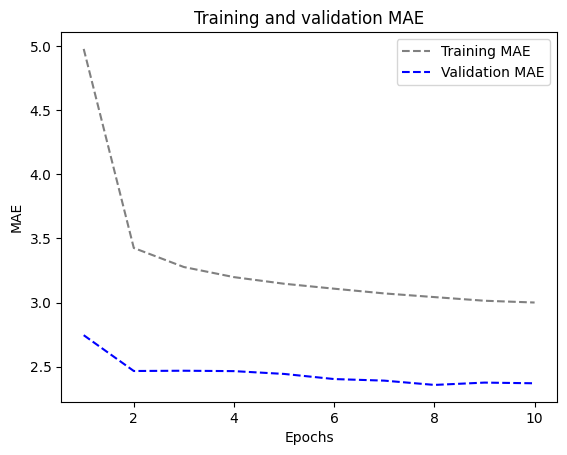

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **3.LSTM - Stacked setup with 16 units**

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 133s 159ms/step - loss: 35.9256 - mae: 4.3340 - val_loss: 11.6420 - val_mae: 2.5813
Epoch 2/10
819/819 [==============================] - 152s 186ms/step - loss: 10.0437 - mae: 2.4570 - val_loss: 9.4329 - val_mae: 2.3929
Epoch 3/10
819/819 [==============================] - 149s 182ms/step - loss: 8.7705 - mae: 2.3128 - val_loss: 9.4345 - val_mae: 2.4033
Epoch 4/10
819/819 [==============================] - 150s 183ms/step - loss: 8.0437 - mae: 2.2185 - val_loss: 9.4927 - val_mae: 2.4143
Epoch 5/10
819/819 [==============================] - 159s 194ms/step - loss: 7.5863 - mae: 2.1523 - val_loss: 9.9303 - val_mae: 2.4687
Epoch 6/10
819/819 [==============================] - 188s 230ms/step - loss: 7.2485 - mae: 2.1004 - val_loss: 10.8082 - val_mae: 2.5806
Epoch 7/10
819/819 [==============================] - 188s 230ms/step - loss: 6.9021 - mae: 2.0460 - val_loss: 10.2508 - val_mae: 2.5062
Epoch 8/10
819/819 [=======================

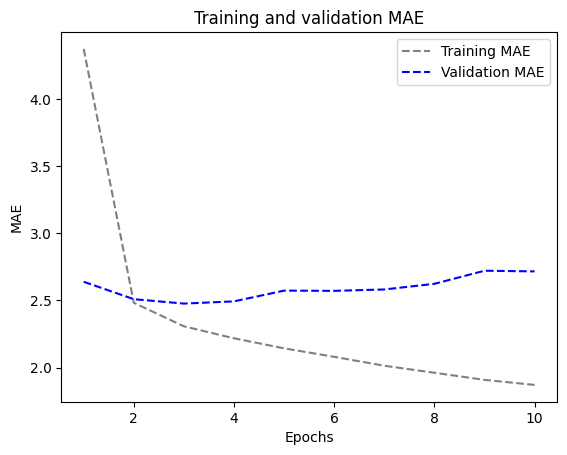

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 32 units**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 317s 376ms/step - loss: 20.8633 - mae: 3.2796 - val_loss: 9.8738 - val_mae: 2.4451
Epoch 2/10
819/819 [==============================] - 337s 411ms/step - loss: 8.1286 - mae: 2.2160 - val_loss: 10.6552 - val_mae: 2.5547
Epoch 3/10
819/819 [==============================] - 335s 409ms/step - loss: 6.6106 - mae: 1.9964 - val_loss: 10.9819 - val_mae: 2.5789
Epoch 4/10
819/819 [==============================] - 334s 408ms/step - loss: 5.6017 - mae: 1.8302 - val_loss: 11.4753 - val_mae: 2.6419
Epoch 5/10
819/819 [==============================] - 334s 408ms/step - loss: 4.8666 - mae: 1.7038 - val_loss: 12.1240 - val_mae: 2.7225
Epoch 6/10
819/819 [==============================] - 313s 382ms/step - loss: 4.4056 - mae: 1.6175 - val_loss: 12.2606 - val_mae: 2.7371
Epoch 7/10
819/819 [==============================] - 335s 409ms/step - loss: 3.9579 - mae: 1.5320 - val_loss: 12.3157 - val_mae: 2.7345
Epoch 8/10
819/819 [=====================

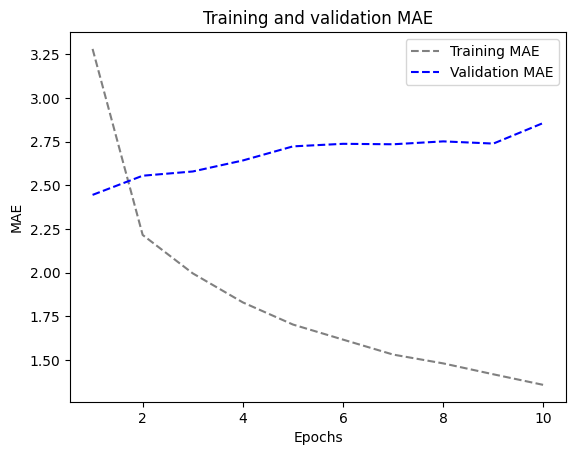

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - Stacked setup with 8 units**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 197s 235ms/step - loss: 67.9970 - mae: 6.2833 - val_loss: 33.2689 - val_mae: 4.2592
Epoch 2/10
819/819 [==============================] - 189s 231ms/step - loss: 20.3320 - mae: 3.3381 - val_loss: 12.7176 - val_mae: 2.6953
Epoch 3/10
819/819 [==============================] - 188s 230ms/step - loss: 11.1049 - mae: 2.5809 - val_loss: 9.6947 - val_mae: 2.4058
Epoch 4/10
819/819 [==============================] - 189s 230ms/step - loss: 9.9952 - mae: 2.4682 - val_loss: 9.3569 - val_mae: 2.3701
Epoch 5/10
819/819 [==============================] - 184s 225ms/step - loss: 9.7076 - mae: 2.4320 - val_loss: 9.2135 - val_mae: 2.3430
Epoch 6/10
819/819 [==============================] - 190s 232ms/step - loss: 9.5343 - mae: 2.4096 - val_loss: 9.0717 - val_mae: 2.3221
Epoch 7/10
819/819 [==============================] - 182s 221ms/step - loss: 9.3864 - mae: 2.3892 - val_loss: 9.3738 - val_mae: 2.3658
Epoch 8/10
819/819 [=======================

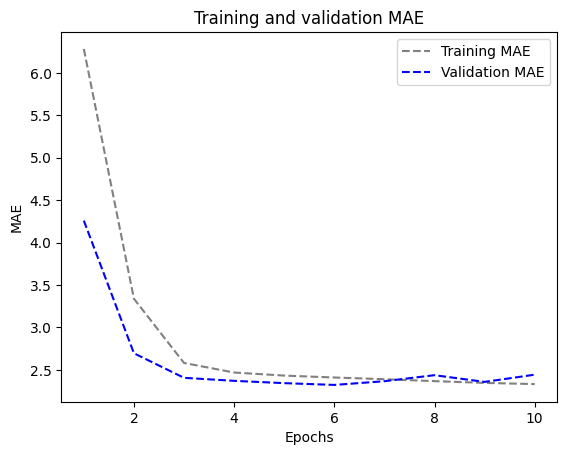

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **6.LSTM - dropout-regularized, stacked model**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 339s 401ms/step - loss: 68.3497 - mae: 6.3318 - val_loss: 31.9592 - val_mae: 4.1894
Epoch 2/10
819/819 [==============================] - 328s 400ms/step - loss: 30.7339 - mae: 4.1587 - val_loss: 13.7660 - val_mae: 2.7925
Epoch 3/10
819/819 [==============================] - 335s 408ms/step - loss: 24.3589 - mae: 3.7376 - val_loss: 11.4791 - val_mae: 2.6121
Epoch 4/10
819/819 [==============================] - 325s 396ms/step - loss: 22.5122 - mae: 3.6008 - val_loss: 10.1713 - val_mae: 2.4624
Epoch 5/10
819/819 [==============================] - 326s 397ms/step - loss: 21.0439 - mae: 3.4853 - val_loss: 10.1551 - val_mae: 2.4668
Epoch 6/10
819/819 [==============================] - 326s 398ms/step - loss: 20.0728 - mae: 3.4028 - val_loss: 9.6235 - val_mae: 2.4028
Epoch 7/10
819/819 [==============================] - 323s 394ms/step - loss: 19.2507 - mae: 3.3356 - val_loss: 9.4450 - val_mae: 2.3810
Epoch 8/10
819/819 [================

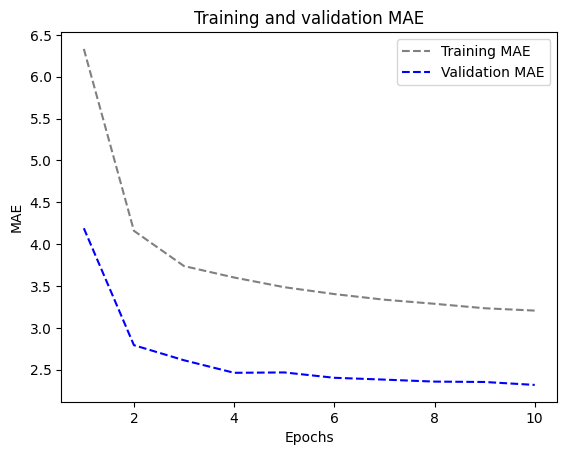

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 206s 244ms/step - loss: 26.7064 - mae: 3.7280 - val_loss: 10.4961 - val_mae: 2.5140
Epoch 2/10
819/819 [==============================] - 211s 257ms/step - loss: 9.7866 - mae: 2.4416 - val_loss: 9.4474 - val_mae: 2.3821
Epoch 3/10
819/819 [==============================] - 196s 239ms/step - loss: 8.8200 - mae: 2.3136 - val_loss: 9.4990 - val_mae: 2.3871
Epoch 4/10
819/819 [==============================] - 197s 240ms/step - loss: 8.2729 - mae: 2.2402 - val_loss: 9.8886 - val_mae: 2.4241
Epoch 5/10
819/819 [==============================] - 214s 261ms/step - loss: 7.8457 - mae: 2.1814 - val_loss: 9.7079 - val_mae: 2.4019
Epoch 6/10
819/819 [==============================] - 209s 255ms/step - loss: 7.5197 - mae: 2.1350 - val_loss: 10.5387 - val_mae: 2.4857
Epoch 7/10
819/819 [==============================] - 212s 258ms/step - loss: 7.2618 - mae: 2.0986 - val_loss: 10.1030 - val_mae: 2.4504
Epoch 8/10
819/819 [========================

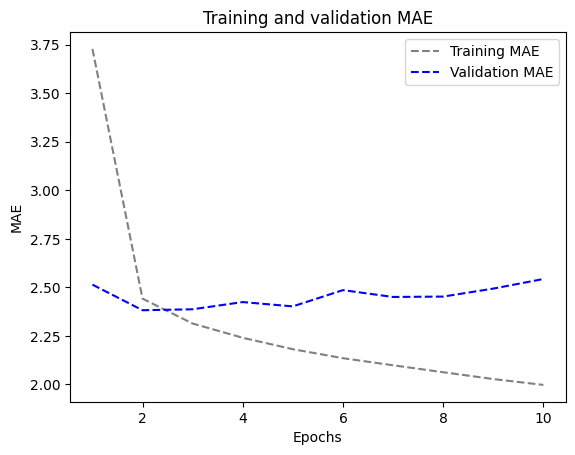

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [39]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 165s 195ms/step - loss: 48.2337 - mae: 5.1927 - val_loss: 26.0842 - val_mae: 3.9649
Epoch 2/10
819/819 [==============================] - 141s 171ms/step - loss: 17.7556 - mae: 3.2618 - val_loss: 25.9483 - val_mae: 3.9713
Epoch 3/10
819/819 [==============================] - 141s 171ms/step - loss: 14.8568 - mae: 2.9929 - val_loss: 22.8474 - val_mae: 3.7509
Epoch 4/10
819/819 [==============================] - 160s 195ms/step - loss: 13.1981 - mae: 2.8098 - val_loss: 21.4173 - val_mae: 3.6718
Epoch 5/10
819/819 [==============================] - 143s 174ms/step - loss: 11.9447 - mae: 2.6690 - val_loss: 25.1948 - val_mae: 3.9363
Epoch 6/10
819/819 [==============================] - 143s 174ms/step - loss: 10.9985 - mae: 2.5558 - val_loss: 23.9628 - val_mae: 3.8181
Epoch 7/10
819/819 [==============================] - 141s 171ms/step - loss: 10.2358 - mae: 2.4598 - val_loss: 24.6256 - val_mae: 4.0109
Epoch 8/10
819/819 [==============

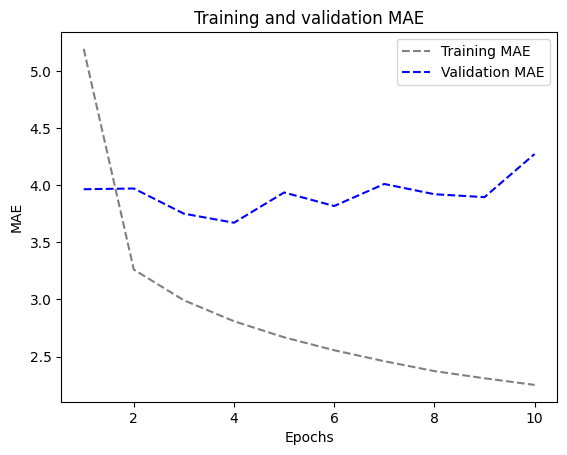

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Built 14 models: Following are the details;

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Simple RNN - Stacking RNN layers

**Model 6:** A Simple GRU (Gated Recurrent Unit)

**Model 7:** LSTM-Simple

**Model 8:** LSTM - dropout Regularization

**Model 9:** Stacked setup with 16 units

**Model 10:** Stacked setup with 32 units

**Model 11:** Stacked setup with 8 units

**Model 12:** LSTM - dropout-regularized, stacked

**Model 13:** Bidirectional LSTM

**Model 14:** 1D Convnets and LSTM togther

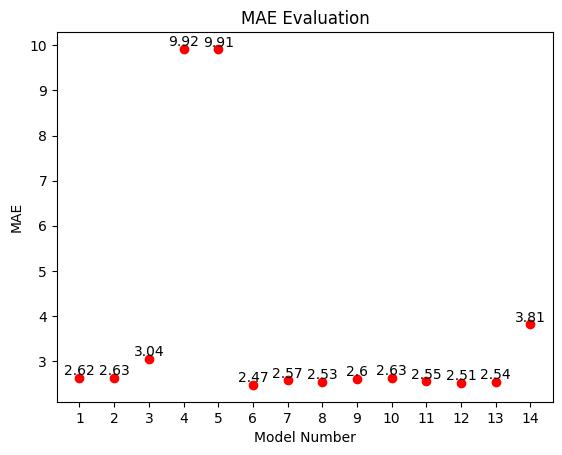

In [41]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.63,3.04,9.92,9.91,2.47,2.57,2.53,2.60,2.63,2.55,2.51,2.54,3.81)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

